In [ ]:
%pip install shap
%pip install ngboost

     |████████████████████████████████| 327kB 7.4MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463912 sha256=fe7ace1f35d6223ce7619fd61743390d8c9c32720478a0da2c9bd215f29c020c
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap
     |████████████████████████████████| 348kB 13.3MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp36-none-any.whl size=4035 sha256=f92a018b6af44e37b1f88973e1c7882d39945a84a179b33e88de5b98ceda0da0
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gamma


In [ ]:
import os
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import sklearn
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold

import shap

import xgboost as xgb
from ngboost import NGBRegressor

from fbprophet import Prophet

import imageio
from datetime import datetime

import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#csv파일 가져오기
from google.colab import files
uploaded = files.upload()

Saving 배급수관로누수_모델_1129_2049.csv to 배급수관로누수_모델_1129_2049.csv


#Data load

In [ ]:
raw_df_base = pd.read_csv('배급수관로누수_모델_1129_2049.csv')
raw_df_base

,RECOVER,GISID,Thickness,Depth,PIP_Kind,Life,Leak_CNT,SAA_CDE,BUILD_Y,BUILD_M,Length,CV_Point,Valve,Train,Area
0,2823,236742,13,6.00,11,27,0,0,2015,11,7,2,0,0,10
1,2947,236732,25,3.00,11,31,0,0,2015,7,3,2,0,0,6
2,3499,236564,25,8.00,11,1,0,0,2018,5,8,2,0,0,6
3,3519,236377,20,15.00,11,3,0,0,2018,4,12,3,0,0,22
4,3461,236137,20,10.00,11,6,0,0,2017,12,9,2,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,2302,100528,200,25.36,4,2,1,1,1979,1,25,2,4,0,42
1060,2161,100528,200,25.36,4,462,0,1,1979,1,25,2,4,0,42
1061,972,100420,300,224.54,4,456,0,1,1978,1,225,16,0,0,4
1062,488,100290,100,43.99,4,124,0,1,2004,12,42,4,2,0,24


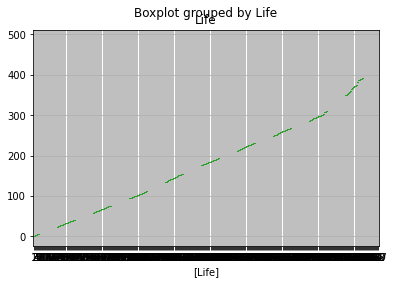

In [ ]:
# Y값(연식) log 처리
raw_df_base.boxplot(column=['Life'], by = ['Life'])

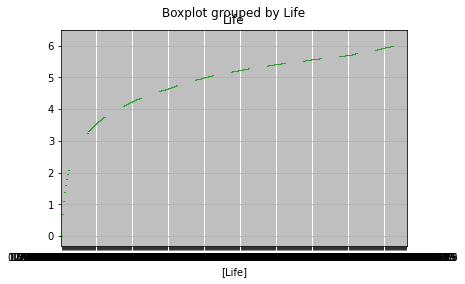

In [ ]:
#로그변환 튄값정리
raw_df_base_log = raw_df_base.copy(deep=True)
raw_df_base_log.Life = np.log(raw_df_base.Life)
raw_df_base_log.boxplot(column = ['Life'], by=['Life'])

In [ ]:
raw_df_base_log.head(10)

,RECOVER,GISID,Thickness,Depth,PIP_Kind,Life,Leak_CNT,SAA_CDE,BUILD_Y,BUILD_M,Length,CV_Point,Valve,Train,Area
0,2823,236742,13,6.0,11,3.295837,0,0,2015,11,7,2,0,0,10
1,2947,236732,25,3.0,11,3.433987,0,0,2015,7,3,2,0,0,6
2,3499,236564,25,8.0,11,0.000000,0,0,2018,5,8,2,0,0,6
3,3519,236377,20,15.0,11,1.098612,0,0,2018,4,12,3,0,0,22
4,3461,236137,20,10.0,11,1.791759,0,0,2017,12,9,2,0,0,3
5,4197,236121,32,4.0,11,2.564949,0,0,2017,11,4,2,1,0,40
6,3778,236046,25,42.0,11,2.397895,0,0,2017,10,42,5,0,0,38
7,3407,235973,80,225.0,8,4.997212,0,0,2006,1,225,16,0,0,38
8,3116,235916,13,16.0,11,0.000000,1,0,2017,8,14,2,0,0,3
9,2677,235916,13,16.0,11,1.609438,0,0,2017,8,14,2,0,0,3


In [ ]:
#더미변수
onehot_cols = ['PIP_Kind','SAA_CDE','Train','Area',]
onehot_cols_df =raw_df_base_log[onehot_cols]
raw_df = pd.get_dummies(raw_df_base_log, columns=onehot_cols)
raw_df.head()

,RECOVER,GISID,Thickness,Depth,Life,Leak_CNT,BUILD_Y,BUILD_M,Length,CV_Point,Valve,PIP_Kind_1,PIP_Kind_2,PIP_Kind_4,PIP_Kind_5,PIP_Kind_6,PIP_Kind_7,PIP_Kind_8,PIP_Kind_10,PIP_Kind_11,PIP_Kind_12,SAA_CDE_0,SAA_CDE_1,Train_0,Train_1,Area_1,Area_2,Area_3,Area_4,Area_5,Area_6,Area_7,Area_8,Area_9,Area_10,Area_11,Area_12,Area_13,Area_14,Area_16,Area_17,Area_18,Area_19,Area_20,Area_21,Area_22,Area_23,Area_24,Area_27,Area_28,Area_29,Area_30,Area_31,Area_32,Area_33,Area_34,Area_35,Area_36,Area_37,Area_38,Area_39,Area_40,Area_41,Area_42,Area_43
0,2823,236742,13,6.0,3.295837,0,2015,11,7,2,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2947,236732,25,3.0,3.433987,0,2015,7,3,2,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3499,236564,25,8.0,0.000000,0,2018,5,8,2,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3519,236377,20,15.0,1.098612,0,2018,4,12,3,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3461,236137,20,10.0,1.791759,0,2017,12,9,2,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#필요없는 변수 제거
cleaned_df = raw_df.copy()

cleaned_df = cleaned_df.drop(columns = ["GISID","RECOVER"])


In [ ]:
cleaned_df.head()

,Thickness,Depth,Life,Leak_CNT,BUILD_Y,BUILD_M,Length,CV_Point,Valve,PIP_Kind_1,PIP_Kind_2,PIP_Kind_4,PIP_Kind_5,PIP_Kind_6,PIP_Kind_7,PIP_Kind_8,PIP_Kind_10,PIP_Kind_11,PIP_Kind_12,SAA_CDE_0,SAA_CDE_1,Train_0,Train_1,Area_1,Area_2,Area_3,Area_4,Area_5,Area_6,Area_7,Area_8,Area_9,Area_10,Area_11,Area_12,Area_13,Area_14,Area_16,Area_17,Area_18,Area_19,Area_20,Area_21,Area_22,Area_23,Area_24,Area_27,Area_28,Area_29,Area_30,Area_31,Area_32,Area_33,Area_34,Area_35,Area_36,Area_37,Area_38,Area_39,Area_40,Area_41,Area_42,Area_43
0,13,6.0,3.295837,0,2015,11,7,2,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,25,3.0,3.433987,0,2015,7,3,2,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,25,8.0,0.000000,0,2018,5,8,2,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,20,15.0,1.098612,0,2018,4,12,3,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20,10.0,1.791759,0,2017,12,9,2,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#Data Preprocessing

In [ ]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2, random_state=7)


# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Life'))
bool_train_labels = train_labels != 0

test_labels = np.array(test_df.pop('Life'))

train_features = np.array(train_df)

test_features = np.array(test_df)

In [ ]:
# 스케일 처리
scaler = MinMaxScaler()
train_features = scaler.fit_transform(train_features)


test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)

test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Training labels nusu sum:', sum(train_labels)) 
print('\n')

print('Test labels shape:', test_labels.shape)
print('testng labels nusu sum: ', sum(test_labels))
print('\n')
print('Training features shape:', train_features.shape)

print('Test features shape:', test_features.shape)


Training labels shape: (851,)
Training labels nusu sum: 3958.833150689139


Test labels shape: (213,)
testng labels nusu sum:  1006.28157439746


Training features shape: (851, 62)
Test features shape: (213, 62)


#XGBOOST

## XGBOOST 격자탐색

In [ ]:
from sklearn.model_selection import GridSearchCV

# XGBoost 분류기 생성
xgb_clf = xgb.XGBRegressor()

# 초모수 격자생성
xgb_param_grid = {"learning_rate" : [0.001, 0.005, 0.01],
                  "n_estimators" : [50, 100, 1000],
                 }

# Create a GridSearchCV object
hr_grid = GridSearchCV(estimator=xgb_clf,
                       param_grid=xgb_param_grid,
                       scoring='neg_mean_squared_error',
                       n_jobs=-1,
                       cv=5,
                       refit=True, 
                       return_train_score=True)

hr_grid.fit(train_features, train_labels)

[17:43:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.005, 0.01],
                         'n_estimators': [50, 100, 1000]},
           

In [ ]:
hr_grid.best_params_ 


{'learning_rate': 0.005, 'n_estimators': 1000}

In [ ]:
hr_grid.best_score_ 

-0.2628339904164456

## XGBOOST 단일 실행

In [ ]:
reg = xgb.XGBRegressor( learning_rate=0.005,n_estimators=1000 ,seed=7)
reg.fit(train_features, train_labels,
        eval_set=[(train_features, train_labels), (test_features, test_labels)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train

[07:01:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.005, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=7, silent=None,
             subsample=1, verbosity=1)

In [ ]:
X_test_pred = reg.predict(test_features)

In [ ]:
#지수변환
test_labels_exp_xg = np.exp(test_labels)
Y_preds_exp_xg = np.exp(X_test_pred)

In [ ]:
#평균 절대 오차
mean_absolute_error(y_true=test_labels_exp_xg,
                   y_pred=Y_preds_exp_xg)

21.21994656408337

In [ ]:
xgb_df = pd.DataFrame({'Predict ':Y_preds_exp_xg, 'Real':test_labels_exp_xg})
xgb_df.head()

,Predict,Real
0,99.651138,116.0
1,132.167480,151.0
2,10.534168,3.0
3,23.894472,29.0
4,223.336044,287.0


#NGBOOST

In [ ]:
ngb = NGBRegressor(n_estimators=300, learning_rate=0.01, random_state=7).fit(train_features, train_labels)
Y_preds = ngb.predict(test_features)
Y_dists = ngb.pred_dist(test_features)

[iter 0] loss=1.5480 val_loss=0.0000 scale=1.0000 norm=1.0862
[iter 100] loss=0.5925 val_loss=0.0000 scale=2.0000 norm=1.1730
[iter 200] loss=0.1116 val_loss=0.0000 scale=2.0000 norm=1.1227


In [ ]:
#지수변환
test_labels_exp = np.exp(test_labels)
Y_preds_exp = np.exp(Y_preds)

In [ ]:
#평균 절대 오차
mean_absolute_error(y_true=test_labels_exp,
                   y_pred=Y_preds_exp)

19.03048461872823

In [ ]:
ngb_df = pd.DataFrame({'Predict':Y_preds_exp, 'Real':test_labels_exp})
ngb_df.head()

,Predict,Real
0,103.131959,116.0
1,136.499845,151.0
2,7.327499,3.0
3,25.540162,29.0
4,229.130451,287.0


In [ ]:
# ngb = NGBRegressor(verbose=False).fit(train_features, train_labels)

## Feature importance for loc trees
feature_importance_loc = ngb.feature_importances_[0]

## Feature importance for scale trees
feature_importance_scale = ngb.feature_importances_[1]

Text(0.5, 1.0, 'scale param')

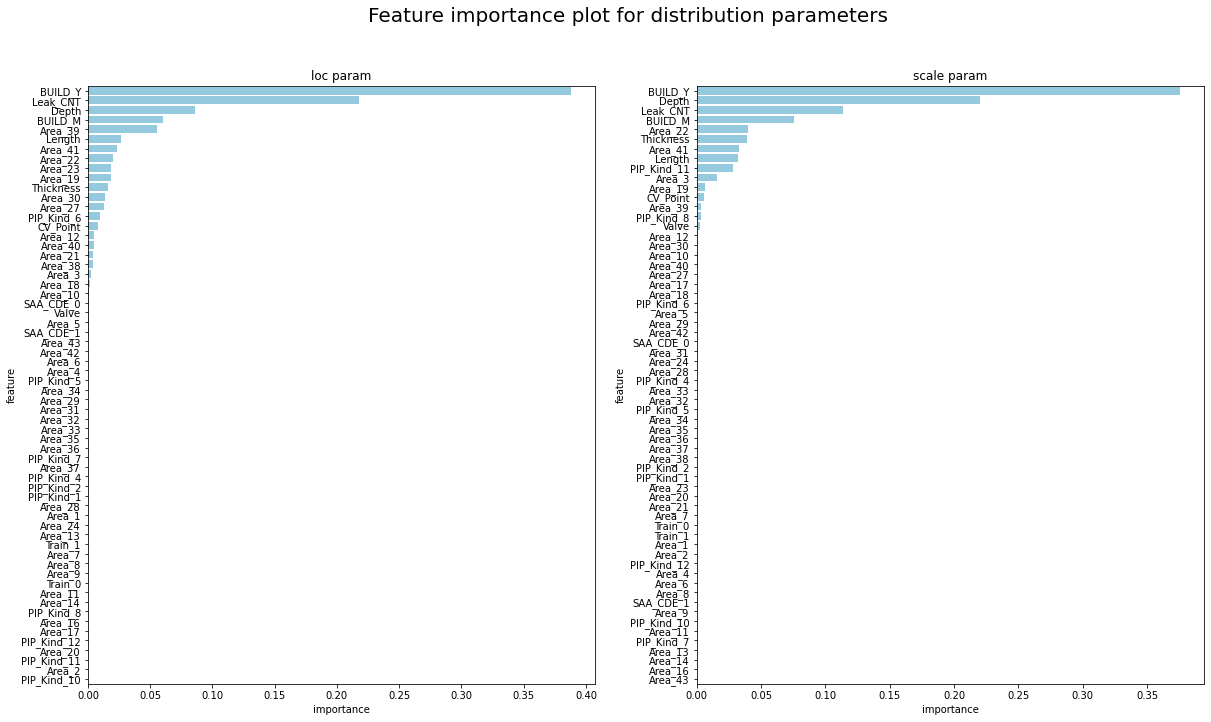

In [ ]:

df_loc = pd.DataFrame({'feature':['Thickness', 'Depth', 'Leak_CNT', 'BUILD_Y', 'BUILD_M',
       'Length', 'CV_Point', 'Valve', 'PIP_Kind_1', 'PIP_Kind_2', 'PIP_Kind_4',
       'PIP_Kind_5', 'PIP_Kind_6', 'PIP_Kind_7', 'PIP_Kind_8', 'PIP_Kind_10',
       'PIP_Kind_11', 'PIP_Kind_12', 'SAA_CDE_0', 'SAA_CDE_1', 'Train_0',
       'Train_1', 'Area_1', 'Area_2', 'Area_3', 'Area_4', 'Area_5', 'Area_6',
       'Area_7', 'Area_8', 'Area_9', 'Area_10', 'Area_11', 'Area_12',
       'Area_13', 'Area_14', 'Area_16', 'Area_17', 'Area_18', 'Area_19',
       'Area_20', 'Area_21', 'Area_22', 'Area_23', 'Area_24', 'Area_27',
       'Area_28', 'Area_29', 'Area_30', 'Area_31', 'Area_32', 'Area_33',
       'Area_34', 'Area_35', 'Area_36', 'Area_37', 'Area_38', 'Area_39',
       'Area_40', 'Area_41', 'Area_42', 'Area_43'],
                       'importance':feature_importance_loc})\
    .sort_values('importance',ascending=False)
df_scale = pd.DataFrame({'feature':['Thickness', 'Depth', 'Leak_CNT', 'BUILD_Y', 'BUILD_M',
       'Length', 'CV_Point', 'Valve', 'PIP_Kind_1', 'PIP_Kind_2', 'PIP_Kind_4',
       'PIP_Kind_5', 'PIP_Kind_6', 'PIP_Kind_7', 'PIP_Kind_8', 'PIP_Kind_10',
       'PIP_Kind_11', 'PIP_Kind_12', 'SAA_CDE_0', 'SAA_CDE_1', 'Train_0',
       'Train_1', 'Area_1', 'Area_2', 'Area_3', 'Area_4', 'Area_5', 'Area_6',
       'Area_7', 'Area_8', 'Area_9', 'Area_10', 'Area_11', 'Area_12',
       'Area_13', 'Area_14', 'Area_16', 'Area_17', 'Area_18', 'Area_19',
       'Area_20', 'Area_21', 'Area_22', 'Area_23', 'Area_24', 'Area_27',
       'Area_28', 'Area_29', 'Area_30', 'Area_31', 'Area_32', 'Area_33',
       'Area_34', 'Area_35', 'Area_36', 'Area_37', 'Area_38', 'Area_39',
       'Area_40', 'Area_41', 'Area_42', 'Area_43'],
                       'importance':feature_importance_scale})\
    .sort_values('importance',ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,11))
fig.suptitle("Feature importance plot for distribution parameters", fontsize=20)
sns.barplot(x='importance',y='feature',ax=ax1,data=df_loc, color="skyblue").set_title('loc param')
sns.barplot(x='importance',y='feature',ax=ax2,data=df_scale, color="skyblue").set_title('scale param')

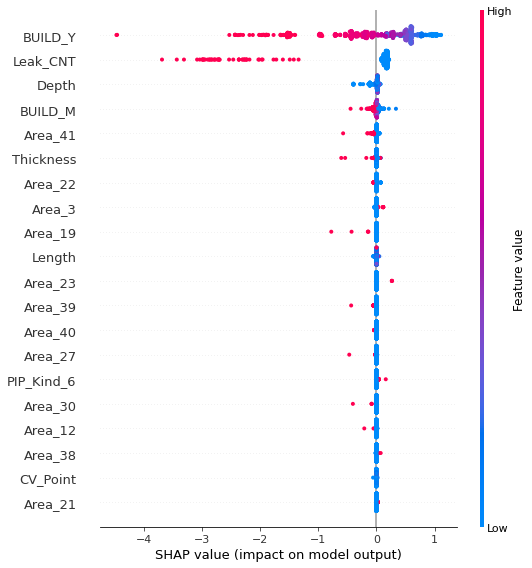

In [ ]:
shap.initjs()

## SHAP plot for loc trees
explainer = shap.TreeExplainer(ngb, model_output=0) # use model_output = 1 for scale trees
shap_values = explainer.shap_values(train_features)
shap.summary_plot(shap_values, train_features, feature_names=['Thickness', 'Depth', 'Leak_CNT', 'BUILD_Y', 'BUILD_M',
       'Length', 'CV_Point', 'Valve', 'PIP_Kind_1', 'PIP_Kind_2', 'PIP_Kind_4',
       'PIP_Kind_5', 'PIP_Kind_6', 'PIP_Kind_7', 'PIP_Kind_8', 'PIP_Kind_10',
       'PIP_Kind_11', 'PIP_Kind_12', 'SAA_CDE_0', 'SAA_CDE_1', 'Train_0',
       'Train_1', 'Area_1', 'Area_2', 'Area_3', 'Area_4', 'Area_5', 'Area_6',
       'Area_7', 'Area_8', 'Area_9', 'Area_10', 'Area_11', 'Area_12',
       'Area_13', 'Area_14', 'Area_16', 'Area_17', 'Area_18', 'Area_19',
       'Area_20', 'Area_21', 'Area_22', 'Area_23', 'Area_24', 'Area_27',
       'Area_28', 'Area_29', 'Area_30', 'Area_31', 'Area_32', 'Area_33',
       'Area_34', 'Area_35', 'Area_36', 'Area_37', 'Area_38', 'Area_39',
       'Area_40', 'Area_41', 'Area_42', 'Area_43'])

#최종 모델 적용

In [ ]:
#csv파일 가져오기
from google.colab import files
uploaded = files.upload()

Saving 배급수관로누수_PIPE_Predict_1220_0007.csv to 배급수관로누수_PIPE_Predict_1220_0007.csv


In [ ]:
raw_df_base = pd.read_csv('배급수관로누수_PIPE_Predict_1220_0007.csv')
raw_df_base

,GISID,SAA_CDE,BUILD_Y,BUILD_M,Thickness,Depth,PIP_Kind,Length,CV_Point,Valve,Train,Area,Leak_CNT
0,230174,0,2010,6,20,7.3,11,10,2,0,0,22,0
1,230175,0,2010,6,20,2.4,11,3,2,0,0,22,0
2,230176,0,2011,6,50,23.0,11,37,3,0,0,41,0
3,230177,0,2011,6,50,32.0,11,26,2,0,0,41,0
4,230178,0,2010,2,13,4.0,11,10,2,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55083,142695,1,2020,5,100,4.0,4,4,2,0,0,7,0
55084,142698,1,2020,6,80,34.0,4,35,3,0,0,43,0
55085,142699,1,2002,1,32,24.0,4,23,4,0,0,18,0
55086,142701,1,2020,5,100,323.0,4,275,26,1,0,27,0


In [ ]:
#더미변수
onehot_cols = ['PIP_Kind','SAA_CDE','Train','Area',]
onehot_cols_df =raw_df_base[onehot_cols]
raw_df = pd.get_dummies(raw_df_base, columns=onehot_cols)
raw_df.head()

,GISID,BUILD_Y,BUILD_M,Thickness,Depth,Length,CV_Point,Valve,Leak_CNT,PIP_Kind_1,PIP_Kind_2,PIP_Kind_3,PIP_Kind_4,PIP_Kind_5,PIP_Kind_6,PIP_Kind_7,PIP_Kind_8,PIP_Kind_9,PIP_Kind_10,PIP_Kind_11,PIP_Kind_12,PIP_Kind_13,SAA_CDE_0,SAA_CDE_1,Train_0,Train_1,Area_1,Area_2,Area_3,Area_4,Area_5,Area_6,Area_7,Area_8,Area_9,Area_10,Area_11,Area_12,Area_13,Area_14,Area_15,Area_16,Area_17,Area_18,Area_19,Area_20,Area_21,Area_22,Area_23,Area_24,Area_25,Area_26,Area_27,Area_28,Area_29,Area_30,Area_31,Area_32,Area_33,Area_34,Area_35,Area_36,Area_37,Area_38,Area_39,Area_40,Area_41,Area_42,Area_43
0,230174,2010,6,20,7.3,10,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,230175,2010,6,20,2.4,3,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,230176,2011,6,50,23.0,37,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,230177,2011,6,50,32.0,26,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,230178,2010,2,13,4.0,10,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#필요없는 변수 제거
cleaned_df = raw_df.copy()

cleaned_df = cleaned_df.drop(columns = ["GISID"])


In [ ]:
cleaned_df.head()

,BUILD_Y,BUILD_M,Thickness,Depth,Length,CV_Point,Valve,Leak_CNT,PIP_Kind_1,PIP_Kind_2,PIP_Kind_3,PIP_Kind_4,PIP_Kind_5,PIP_Kind_6,PIP_Kind_7,PIP_Kind_8,PIP_Kind_9,PIP_Kind_10,PIP_Kind_11,PIP_Kind_12,PIP_Kind_13,SAA_CDE_0,SAA_CDE_1,Train_0,Train_1,Area_1,Area_2,Area_3,Area_4,Area_5,Area_6,Area_7,Area_8,Area_9,Area_10,Area_11,Area_12,Area_13,Area_14,Area_15,Area_16,Area_17,Area_18,Area_19,Area_20,Area_21,Area_22,Area_23,Area_24,Area_25,Area_26,Area_27,Area_28,Area_29,Area_30,Area_31,Area_32,Area_33,Area_34,Area_35,Area_36,Area_37,Area_38,Area_39,Area_40,Area_41,Area_42,Area_43
0,2010,6,20,7.3,10,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2010,6,20,2.4,3,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2011,6,50,23.0,37,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,2011,6,50,32.0,26,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,2010,2,13,4.0,10,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Use a utility from sklearn to split and shuffle our dataset.
test_df =cleaned_df

# Form np arrays of labels and features.
test_features = np.array(test_df)

In [ ]:
# 스케일 처리
scaler = MinMaxScaler()
test_features = scaler.fit_transform(test_features)

test_features = np.clip(test_features, -5, 5)

print('Test labels shape:', test_labels.shape)
print('testng labels nusu sum: ', sum(test_labels))
print('\n')
print('Test features shape:', test_features.shape)


Test labels shape: (213,)
testng labels nusu sum:  1006.28157439746


Test features shape: (55088, 68)


In [ ]:
Y_preds = ngb.predict(test_features)

In [ ]:
Y_preds

array([5.94374706, 5.94374706, 5.97508403, ..., 5.72133438, 5.9095001 ,
       5.97479808])

In [ ]:
#지수변환
Y_preds_exp = np.exp(Y_preds)

In [ ]:
remain_life= round((Y_preds_exp/12)-(2021-raw_df_base['BUILD_Y']))

In [ ]:
raw_df_base['remain_life'] = remain_life

In [ ]:
raw_df_base

,GISID,SAA_CDE,BUILD_Y,BUILD_M,Thickness,Depth,PIP_Kind,Length,CV_Point,Valve,Train,Area,Leak_CNT,remain_life
0,230174,0,2010,6,20,7.3,11,10,2,0,0,22,0,21.0
1,230175,0,2010,6,20,2.4,11,3,2,0,0,22,0,21.0
2,230176,0,2011,6,50,23.0,11,37,3,0,0,41,0,23.0
3,230177,0,2011,6,50,32.0,11,26,2,0,0,41,0,22.0
4,230178,0,2010,2,13,4.0,11,10,2,0,0,3,0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55083,142695,1,2020,5,100,4.0,4,4,2,0,0,7,0,31.0
55084,142698,1,2020,6,80,34.0,4,35,3,0,0,43,0,32.0
55085,142699,1,2002,1,32,24.0,4,23,4,0,0,18,0,6.0
55086,142701,1,2020,5,100,323.0,4,275,26,1,0,27,0,30.0


In [ ]:
#결과값 저장
raw_df_base.to_csv('ngb_predict_final.csv', index=False, encoding='cp949')

In [ ]:
#설명용 shap

# load JS visualization code to notebook
shap.initjs()

# test NGBoost model
model = xgb.train({"learning_rate": 0.01}, xgb.DMatrix(train_features, label=np.exp(train_labels)), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_features)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[7,:], train_features[7,:], feature_names=['Thickness', 'Depth', 'Leak_CNT', 'BUILD_Y', 'BUILD_M',
       'Length', 'CV_Point', 'Valve', 'PIP_Kind_1', 'PIP_Kind_2', 'PIP_Kind_4',
       'PIP_Kind_5', 'PIP_Kind_6', 'PIP_Kind_7', 'PIP_Kind_8', 'PIP_Kind_10',
       'PIP_Kind_11', 'PIP_Kind_12', 'SAA_CDE_0', 'SAA_CDE_1', 'Train_0',
       'Train_1', 'Area_1', 'Area_2', 'Area_3', 'Area_4', 'Area_5', 'Area_6',
       'Area_7', 'Area_8', 'Area_9', 'Area_10', 'Area_11', 'Area_12',
       'Area_13', 'Area_14', 'Area_16', 'Area_17', 'Area_18', 'Area_19',
       'Area_20', 'Area_21', 'Area_22', 'Area_23', 'Area_24', 'Area_27',
       'Area_28', 'Area_29', 'Area_30', 'Area_31', 'Area_32', 'Area_33',
       'Area_34', 'Area_35', 'Area_36', 'Area_37', 'Area_38', 'Area_39',
       'Area_40', 'Area_41', 'Area_42', 'Area_43'])